In [1]:
import os, gc, sys
from glob import glob
from tqdm.notebook import tqdm
import itertools
import pandas as pd

import re

In [2]:
prefix = os.getcwd().split("jdi-qasp-ml")[0]
sys.path.append(os.path.join(prefix, "jdi-qasp-ml"))
model_path = os.path.join(prefix, "jdi-qasp-ml", "HTML5_model/model")
df_path = os.path.join(prefix, "jdi-qasp-ml", "data/html5_dataset/df")

In [3]:
ds_files = glob(f"{df_path}/html5*.pkl")
df = pd.DataFrame()
for file in tqdm(ds_files[:200]):
    df_1 = pd.read_pickle(file)
    df_1['label'] = df_1.attributes.apply(lambda x: None if (None if x is None else x.get("data-label")) is None else x.get("data-label")).fillna("n/a")
    df_1['attributes_list'] = df_1.attributes.apply(lambda x: "" if x is None else " ".join(list(x.keys())))
    df_1["type"] = df_1.attributes.apply(lambda x: None if (None if x is None else x.get("type")) is None else x.get("type")).fillna("n/a")
    par_childs = {par:list(df_1[df_1.parent_id==par].element_id.unique()) for par in df_1.parent_id.unique()}
    df_1['childs'] = df_1['element_id'].apply(lambda x: par_childs.get(x))
    df_1["childs_types"] = df_1['childs'].apply(lambda l : [None] if l is None else [df_1[df_1.element_id==i].type.iloc[0] if df_1[df_1.element_id==i].type.iloc[0] != "n/a" else None for i in l])
    df_1["is_checkbox_in_childs"] = df_1["childs_types"].apply(lambda x: 1 if "checkbox" in x else 0)
    df_1["is_radio_in_childs"] = df_1["childs_types"].apply(lambda x: 1 if "radio" in x else 0)
    df = pd.concat([df, df_1]).reset_index(drop=True)

df.to_parquet(f"{prefix}jdi-qasp-ml/data/html5_dataset/html5_full_dataset.parquet")

  0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
df[df.is_checkbox_in_childs == 1].head(1)

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,...,width,x,y,label,attributes_list,type,childs,childs_types,is_checkbox_in_childs,is_radio_in_childs
7,"{'class': '5d18d19b', 'data-label': 'checklist...",True,4810673372929225635711386759,28.0,"<div id=""11731af9"" class=""5d18d19b"" style=""col...",None,None,7083480194929225636179133956,"[accent-color, align-content, align-items, ali...",DIV,...,1390.0,20.0,10.0,checklist,class data-label id name style,n/a,"[6349810714929225634404321017, 165621753892922...","[None, checkbox, checkbox, None, None, checkbo...",1,0


In [5]:
dataset = df[["element_id", "tag_name", "attributes_list", "type", "is_checkbox_in_childs", "is_radio_in_childs", "label"]]

In [6]:
dataset.head()

,element_id,tag_name,attributes_list,type,is_checkbox_in_childs,is_radio_in_childs,label
0,9083127097929225632610037211,HTML,lang,n/a,0,0,n/a
1,8587583832929225631480569526,HEAD,,n/a,0,0,n/a
2,0531748475929225633877253882,META,charset,n/a,0,0,n/a
3,6555582029929225637459027144,TITLE,,n/a,0,0,n/a
4,4136841822929225636687813383,STYLE,,n/a,0,0,n/a


In [8]:
df.label.unique()

array(['n/a', 'checklist', 'label', 'checkbox', 'textfield', 'datalist',
       'textarea', 'range', 'colorpicker', 'fileinput', 'button', 'link',
       'title', 'multidropdown', 'multiselector', 'table',
       'numberselector', 'progressbar', 'datetimeselector', 'text',
       'radiobuttongroup', 'radiobutton', 'dropdown'], dtype=object)

In [12]:
dataset.type.unique()

array(['n/a', 'checkbox', 'text', 'range', 'color', 'file', 'button',
       'number', 'datetime-local', 'radio', 'month', 'text/xml', 'date',
       'week', 'image/tiff', 'multipart/mixed', 'text/csv', 'reset',
       'image/jpeg', 'application/atom+xml', 'submit',
       'application/EDI-X12', 'time', 'video/mp4', 'model/x3d+xml',
       'application/rdf+xml', 'video/ogg', 'image/svg+xml',
       'multipart/form-data', 'model/iges', 'message/partial',
       'text/html', 'application/javascript', 'application/ogg',
       'application/pdf', 'audio/vnd.wave', 'application/font-woff',
       'image/gif', 'text/css', 'audio/ogg', 'audio/vnd.rn-realaudio',
       'message/rfc822', 'audio/vorbis', 'message/http', 'model/example',
       'message/imdn+xml', 'text/plain', 'application/EDIFACT',
       'audio/webm', 'model/mesh', 'text/javascript', 'multipart/related',
       'text/vcard', 'image/vnd.microsoft.icon', 'video/x-matroska',
       'model/x3d+binary', 'application/octet-stream', 

In [13]:
buf_types = set([i for i in dataset.type.unique() if (not "/" in i or i == "n/a")])
buf_types

{'button',
 'checkbox',
 'color',
 'date',
 'datetime-local',
 'file',
 'month',
 'n/a',
 'number',
 'radio',
 'range',
 'reset',
 'submit',
 'text',
 'time',
 'week'}

In [14]:
buf = re.sub(" +", " ", " ".join(dataset.attributes_list.to_list()))
attr_columns = list(set([i for i in set(buf.split(" ")) if "font-size" not in i]) - set(["data-label", "label", "id", "name", "type", "class", "style", "disabled"]))
tag_columns = list(dataset.tag_name.unique())
type_columns = list(buf_types-set(["n/a"]))
print(attr_columns)
print(tag_columns)
print(type_columns)

['accept', 'value', 'wrap', 'download', 'ping', 'referrerpolicy', 'target', 'capture', 'pattern', 'href', 'autocomplete', 'required', 'max', 'readonly', 'multiple', 'maxlength', 'rel', 'charset', 'step', 'for', 'checked', 'rows', 'formenctype', 'list', 'indeterminate', 'spellcheck', 'placeholder', 'minlength', 'cols', 'min', 'formaction', 'size', 'lang']
['HTML', 'HEAD', 'META', 'TITLE', 'STYLE', 'BODY', 'DIV', 'LABEL', 'INPUT', 'DATALIST', 'OPTION', 'TEXTAREA', 'FORM', 'A', 'H2', 'SELECT', 'TABLE', 'TBODY', 'TR', 'TD', 'PROGRESS', 'P', 'H5', 'BR', 'H6', 'H1', 'H3', 'BUTTON', 'H4']
['number', 'file', 'text', 'color', 'week', 'reset', 'radio', 'submit', 'month', 'time', 'checkbox', 'range', 'button', 'datetime-local', 'date']


In [15]:
for col in tqdm(attr_columns):
    dataset.loc[:, "attr_"+col] = dataset.loc[:, "attributes_list"].apply(lambda x: 1 if col in x else 0).values

for col in tqdm(tag_columns):
    dataset.loc[:, "tag_"+col] = dataset.loc[:, "tag_name"].apply(lambda x: 1 if col == x else 0).values

for col in tqdm(type_columns):
    dataset.loc[:, "type_"+col] = dataset.loc[:, "type"].apply(lambda x: 1 if col == x else 0).values

attr_columns = ["attr_"+col for col in attr_columns]

tag_columns = ["tag_"+col for col in tag_columns]

type_columns = ["type_"+col for col in type_columns]


  0%|          | 0/33 [00:00<?, ?it/s]

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
print(attr_columns)
print(tag_columns)
print(type_columns)

['attr_accept', 'attr_value', 'attr_wrap', 'attr_download', 'attr_ping', 'attr_referrerpolicy', 'attr_target', 'attr_capture', 'attr_pattern', 'attr_href', 'attr_autocomplete', 'attr_required', 'attr_max', 'attr_readonly', 'attr_multiple', 'attr_maxlength', 'attr_rel', 'attr_charset', 'attr_step', 'attr_for', 'attr_checked', 'attr_rows', 'attr_formenctype', 'attr_list', 'attr_indeterminate', 'attr_spellcheck', 'attr_placeholder', 'attr_minlength', 'attr_cols', 'attr_min', 'attr_formaction', 'attr_size', 'attr_lang']
['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE', 'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_DATALIST', 'tag_OPTION', 'tag_TEXTAREA', 'tag_FORM', 'tag_A', 'tag_H2', 'tag_SELECT', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD', 'tag_PROGRESS', 'tag_P', 'tag_H5', 'tag_BR', 'tag_H6', 'tag_H1', 'tag_H3', 'tag_BUTTON', 'tag_H4']
['type_number', 'type_file', 'type_text', 'type_color', 'type_week', 'type_reset', 'type_radio', 'type_submit', 'type_month', 'typ

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataset["label"] = le.fit_transform(dataset["label"])

In [18]:
DF = dataset[tag_columns + attr_columns 
                + type_columns 
                + ["is_checkbox_in_childs", "is_radio_in_childs", "label"]]

In [19]:
pd.DataFrame({"classes":le.classes_, "codes": le.transform(le.classes_)})

,classes,codes
0,button,0
1,checkbox,1
2,checklist,2
3,colorpicker,3
4,datalist,4
5,datetimeselector,5
6,dropdown,6
7,fileinput,7
8,label,8
9,link,9


In [20]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
DF.shape

(158170, 80)

In [22]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy={i:30000 for i in le.transform(le.classes_) if i != 12})

In [23]:
X_train, X_test, y_train, y_test = train_test_split(DF.drop(columns=["label"]), DF.label, test_size=0.2)
X_over, y_over = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_over.shape)

(126536, 79)
(728579, 79)


In [24]:
X_train.columns

Index(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_DATALIST',
       'tag_OPTION', 'tag_TEXTAREA', 'tag_FORM', 'tag_A', 'tag_H2',
       'tag_SELECT', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD',
       'tag_PROGRESS', 'tag_P', 'tag_H5', 'tag_BR', 'tag_H6', 'tag_H1',
       'tag_H3', 'tag_BUTTON', 'tag_H4', 'attr_accept', 'attr_value',
       'attr_wrap', 'attr_download', 'attr_ping', 'attr_referrerpolicy',
       'attr_target', 'attr_capture', 'attr_pattern', 'attr_href',
       'attr_autocomplete', 'attr_required', 'attr_max', 'attr_readonly',
       'attr_multiple', 'attr_maxlength', 'attr_rel', 'attr_charset',
       'attr_step', 'attr_for', 'attr_checked', 'attr_rows',
       'attr_formenctype', 'attr_list', 'attr_indeterminate',
       'attr_spellcheck', 'attr_placeholder', 'attr_minlength', 'attr_cols',
       'attr_min', 'attr_formaction', 'attr_size', 'attr_lang', 'type_number',
       'type_file',

In [25]:
print(X_test.shape)

(31634, 79)


In [26]:
X_train.columns

Index(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_DATALIST',
       'tag_OPTION', 'tag_TEXTAREA', 'tag_FORM', 'tag_A', 'tag_H2',
       'tag_SELECT', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD',
       'tag_PROGRESS', 'tag_P', 'tag_H5', 'tag_BR', 'tag_H6', 'tag_H1',
       'tag_H3', 'tag_BUTTON', 'tag_H4', 'attr_accept', 'attr_value',
       'attr_wrap', 'attr_download', 'attr_ping', 'attr_referrerpolicy',
       'attr_target', 'attr_capture', 'attr_pattern', 'attr_href',
       'attr_autocomplete', 'attr_required', 'attr_max', 'attr_readonly',
       'attr_multiple', 'attr_maxlength', 'attr_rel', 'attr_charset',
       'attr_step', 'attr_for', 'attr_checked', 'attr_rows',
       'attr_formenctype', 'attr_list', 'attr_indeterminate',
       'attr_spellcheck', 'attr_placeholder', 'attr_minlength', 'attr_cols',
       'attr_min', 'attr_formaction', 'attr_size', 'attr_lang', 'type_number',
       'type_file',

In [27]:
DecisionTreeClassifier()._get_param_names()

['ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'random_state',
 'splitter']

In [28]:
parameters = {'max_depth':range(20,25), 'criterion': ["gini", "entropy"], 'min_samples_split': range(2,5), 'min_samples_leaf': range(1,2)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
clf.fit(X=X_over, y=y_over)
tree_model = clf.best_estimator_

In [29]:
clf.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 23,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
print(classification_report(y_over, tree_model.predict(X_over), target_names=le.classes_))

                  precision    recall  f1-score   support

          button       1.00      1.00      1.00     30000
        checkbox       1.00      1.00      1.00     30000
       checklist       1.00      1.00      1.00     30000
     colorpicker       1.00      1.00      1.00     30000
        datalist       1.00      1.00      1.00     30000
datetimeselector       1.00      1.00      1.00     30000
        dropdown       1.00      1.00      1.00     30000
       fileinput       1.00      1.00      1.00     30000
           label       1.00      1.00      1.00     30000
            link       1.00      1.00      1.00     30000
   multidropdown       1.00      1.00      1.00     30000
   multiselector       1.00      1.00      1.00     30000
             n/a       1.00      1.00      1.00     68579
  numberselector       1.00      1.00      1.00     30000
     progressbar       1.00      1.00      1.00     30000
     radiobutton       1.00      1.00      1.00     30000
radiobuttongr

In [32]:
y_pred = tree_model.predict(X_test)

In [33]:

print(classification_report(y_test, y_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

          button       1.00      1.00      1.00       302
        checkbox       1.00      1.00      1.00      2019
       checklist       1.00      1.00      1.00       274
     colorpicker       1.00      1.00      1.00       288
        datalist       1.00      1.00      1.00       266
datetimeselector       1.00      1.00      1.00       284
        dropdown       1.00      1.00      1.00       284
       fileinput       1.00      1.00      1.00       306
           label       1.00      1.00      1.00      5207
            link       1.00      1.00      1.00       277
   multidropdown       1.00      1.00      1.00       271
   multiselector       1.00      1.00      1.00       296
             n/a       1.00      1.00      1.00     17300
  numberselector       1.00      1.00      1.00       283
     progressbar       1.00      1.00      1.00       262
     radiobutton       1.00      1.00      1.00      1530
radiobuttongr

In [34]:
# print((y_pred[y_test != 7]))
# print((y_test[y_test != 7]))

In [35]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[y_test != 12], y_pred[y_test != 12])

1.0

In [36]:
test_res = pd.DataFrame({"y_test":y_test, "y_pred":y_pred, "label_test":le.inverse_transform(y_test), "label_pred":le.inverse_transform(y_pred)})
test_res["str"] = test_res.label_test+ "-" +test_res.label_pred

In [37]:
test_res[test_res.y_test != test_res.y_pred]

,y_test,y_pred,label_test,label_pred,str


In [38]:
df[df.label.isin(['checklist'])].attributes_list

7                  class data-label id name style
178                class data-label id name style
322                class data-label id name style
344                class data-label id name style
724                class data-label id name style
                           ...                   
157717             class data-label id name style
157766    class data-label disabled id name style
157941             class data-label id name style
158046             class data-label id name style
158149    class data-label disabled id name style
Name: attributes_list, Length: 1425, dtype: object

In [39]:
test_res[test_res.y_test != test_res.y_pred].str.unique()

array([], dtype=object)

In [40]:
df[(df.tag_name=='DATALIST')&(df.label!='datalist')]

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,...,width,x,y,label,attributes_list,type,childs,childs_types,is_checkbox_in_childs,is_radio_in_childs
19,{'id': 'datalist-c8c33181'},False,6378307628929225644167942181,0.0,"<datalist id=""datalist-c8c33181"">\n ...",None,None,3773929715929225648324889042,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id,n/a,"[7945740234929225640301656305, 207032439292922...","[None, None, None, None, None, None, None, Non...",0,0
33,"{'id': 'datalist-de227259', 'style': ''}",False,6181469096929225645692831532,0.0,"<datalist id=""datalist-de227259"" style="""">\n ...",None,None,0015811730929225649897678679,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0
46,"{'id': 'datalist-6a15a9d6', 'style': ''}",False,5182772019929225645788495327,0.0,"<datalist id=""datalist-6a15a9d6"" style="""">\n ...",None,None,0552347840929225647607661359,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,"[5000721889929225642428045468, 370969996292922...","[None, None, None, None, None, None, None, Non...",0,0
206,"{'id': 'datalist-0e905027', 'style': ''}",False,8744339844929225652881795479,0.0,"<datalist id=""datalist-0e905027"" style="""">\n ...",None,None,4244285584929225653972672857,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0
281,{'id': 'datalist-99dbfd7b'},False,3804774012929225653799135773,0.0,"<datalist id=""datalist-99dbfd7b"">\n ...",None,None,7180745812929225650749059008,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id,n/a,"[9290167009929225651595888902, 250145378092922...","[None, None, None, None, None, None, None, None]",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158018,"{'id': 'datalist-065a2493', 'style': ''}",False,8301849195931500522282458450,0.0,"<datalist id=""datalist-065a2493"" style="""">\n ...",None,None,0241702376931500521919831796,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0
158032,"{'id': 'datalist-d15c0c52', 'style': ''}",False,7561082290931500521883193622,0.0,"<datalist id=""datalist-d15c0c52"" style="""">\n ...",None,None,9578059988931500527449701155,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0
158069,"{'id': 'datalist-29b59fb8', 'style': ''}",False,5780491169931500525069166924,0.0,"<datalist id=""datalist-29b59fb8"" style="""">\n ...",None,None,6441009824931500525794775201,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0
158089,"{'id': 'datalist-365aaba8', 'style': ''}",False,2239634774931500528441869454,0.0,"<datalist id=""datalist-365aaba8"" style="""">\n ...",None,None,2278057939931500528808522558,"[accent-color, align-content, align-items, ali...",DATALIST,...,0.0,0.0,0.0,n/a,id style,n/a,None,[None],0,0


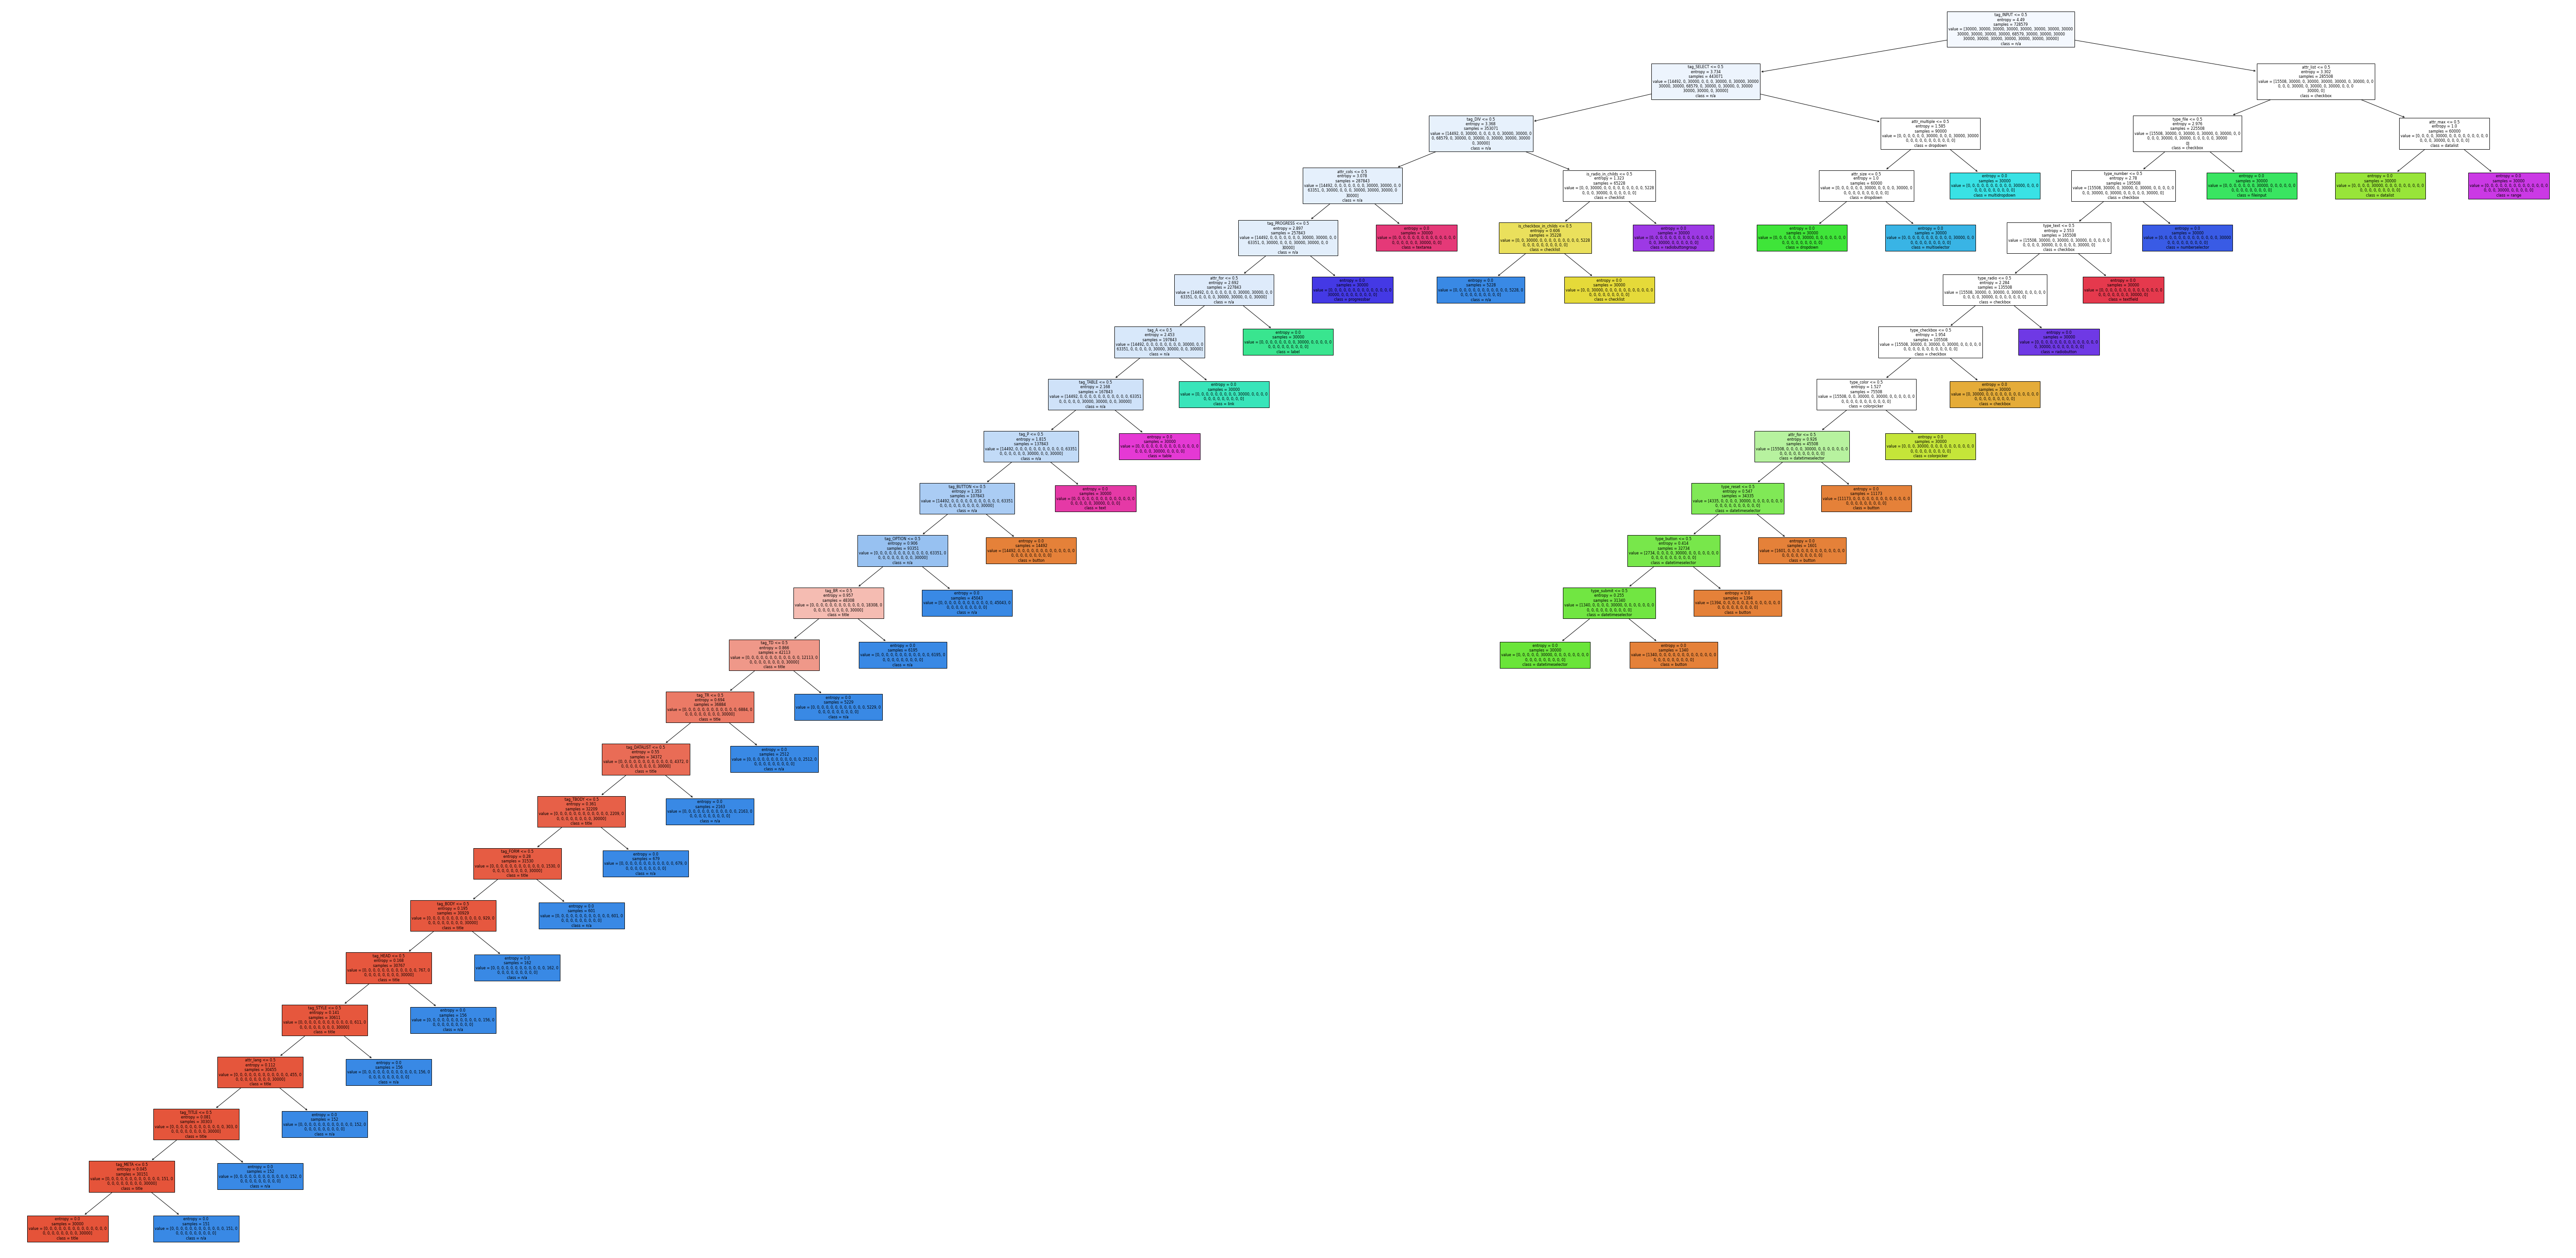

In [41]:
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(100,50))
_ = tree.plot_tree(tree_model, 
                   feature_names=X_train.columns,  
                   class_names=le.classes_,
                   filled=True)